# Compare RSCAN and PBE alpha values

### Import statements and custom functions

In [80]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pathlib
import pickle
from scipy import stats
from mpl_toolkits import mplot3d
import seaborn as sns
sns.set()

In [81]:
def return_intersection(hist_1, hist_2):
    """Returns intersection of two sets of histogram data"""
    minima = np.minimum(hist_1, hist_2)
    intersection = np.true_divide(np.sum(minima), np.sum(hist_2))
    return intersection

In [82]:
def compare_hist(mag,mag_pbe):
    """Generates statistical comparison of alpha lists"""
    data = []
    for alpha in range(1,len(mag[list(mag.keys())[0]].keys())+1):
        for atom in mag.keys():    
            a1,b,c = plt.hist(mag[atom]['alpha_'+str(alpha)][0],bins=20,alpha=0.5)
            a2,b,c = plt.hist(mag_pbe[atom]['alpha_'+str(alpha)][0],bins=20,alpha=0.5)
            intersect = return_intersection(a1,a2)
            statistic , p_wilcox = stats.wilcoxon(a1,a2)
            statistic , p_ks = stats.ks_2samp(a1,a2)
            entropy = stats.entropy(a1, qk=a2, base=None)
            data.append([atom,alpha,p_wilcox,p_ks,intersect,entropy])
    data = np.array(data,ndmin=2)
    mag_comp = pd.DataFrame(data=data,columns=['element','alpha','p_wilcox','p_ks','intersect','entropy'])
    for i in ['p_wilcox','p_ks','intersect','entropy']:
        mag_comp[i] = mag_comp[i].astype('float')
    mag_comp = mag_comp.set_index(['element', 'alpha']).sort_index()
    return mag_comp

In [83]:
from sklearn.neighbors.kde import KernelDensity

def prob_density(X, X_d):
    # initialize kernal density
    kde = KernelDensity(bandwidth=0.04, kernel='epanechnikov')
    # fit it to data
    kde.fit(X[:,None])
    # find log of probability density at points given
    logprob = kde.score_samples(X_d[:,None])
    return np.exp(logprob)


In [84]:

def plot_kde(raw,raw_pbe,element,alpha,lower,upper,loc = 'upper left'):
    X = raw[element][alpha][0]
    Y = raw_pbe[element][alpha][0]
    X_d = np.linspace(lower,upper,100)

    X_prob = prob_density(X,X_d)
    Y_prob = prob_density(Y,X_d)

    plt.fill_between(X_d,X_prob,alpha=0.5)
    plt.fill_between(X_d,Y_prob,alpha=0.5)
    plt.title('RSCAN vs. PBE: '+element+' '+alpha)
    plt.legend(labels=['RSACN','PBE'],loc=loc)

In [85]:
# Generate a tripple nested dictionary of lists of alpha values
def gen_nested_dict(mag,mag_pbe):  
    mag_dict_big = {}
    for element in mag.keys():
        temp_dict = {}
        for alpha in mag[element].keys():
            temp_dict_inner = {}
            temp_dict_inner['RSCAN']=mag[element][alpha][0]
            temp_dict_inner['PBE']=mag_pbe[element][alpha][0]
            temp_dict[alpha]=temp_dict_inner
        mag_dict_big[element]=temp_dict
    return mag_dict_big


In [86]:
# turn tripple nested dictionary into pandas data frame
def gen_df_from_dict(mag_dict_big):   
    mag_big_df = pd.DataFrame.from_dict({(i,j,k): mag_dict_big[i][j][k] 
                               for i in mag_dict_big.keys()
                               for j in mag_dict_big[i].keys()
                               for k in mag_dict_big[i][j].keys()},
                               orient='index')
    # turn tuple columns into multiindex
    mag_big_df.index = pd.MultiIndex.from_tuples(mag_big_df.index)
    mag_big_df = mag_big_df.transpose()
    return mag_big_df


In [87]:
def histo_mega_plot(df,element,num_alpha):
    """Plat set of histograms for PBE and RSCAN"""
    fig, axs = plt.subplots(ncols=num_alpha,figsize=(15,5))
    for i in range(0,num_alpha):
        sns.distplot(df[element]['alpha_'+str(i+1)]['RSCAN'].dropna(),ax=axs[i],label='RSCAN').set_title(element+' alpha_'+str(i+1))
        sns.distplot(df[element]['alpha_'+str(i+1)]['PBE'].dropna(),ax=axs[i],label='PBE')
        axs[i].legend()
        axs[i].set(xlabel="alpha")
       

## Load data and build DataFrames

### Spin-polarized materials

In [88]:
# load data structure 
with open('./ferro_mag_extreme/data.obj','rb') as myfile:
     mag = pickle.load(myfile)

In [89]:
# load data structure 
with open('./ferro_magnetic_PBE/data.obj','rb') as myfile:
     mag_pbe = pickle.load(myfile)

In [90]:
mag_df = gen_df_from_dict(gen_nested_dict(mag,mag_pbe))

### Non-Spin-pol materials

In [91]:
# load data structure 
with open('./non_mag_paper/data.obj','rb') as myfile:
     non_mag = pickle.load(myfile)

In [92]:
# load data structure 
with open('./non_mag_PBE/data.obj','rb') as myfile:
     non_mag_pbe = pickle.load(myfile)

In [93]:
non_mag_df = gen_df_from_dict(gen_nested_dict(non_mag,non_mag_pbe))

# Histogram and Kernal Density Estimate analysis

## Spin Polarized Materials

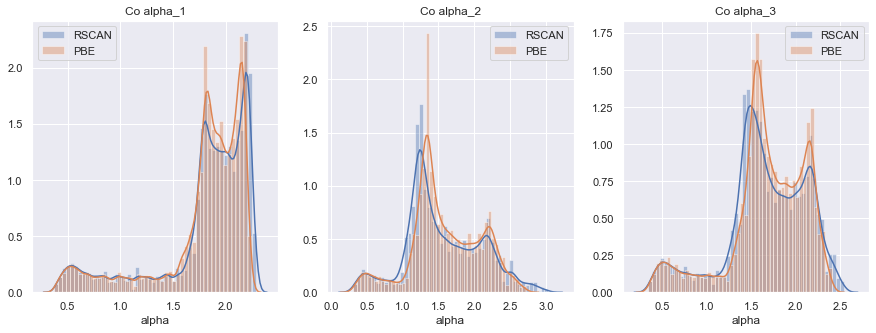

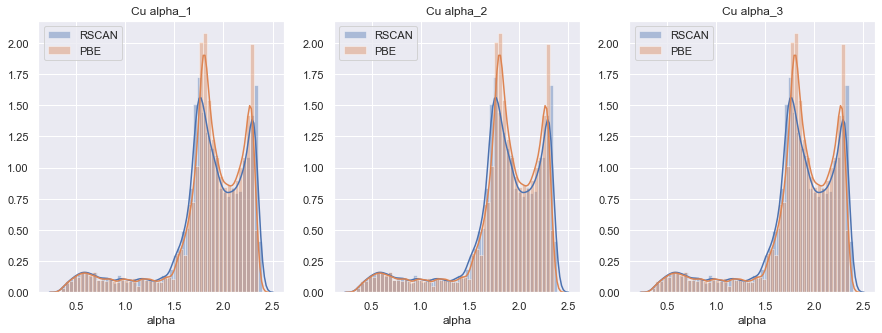

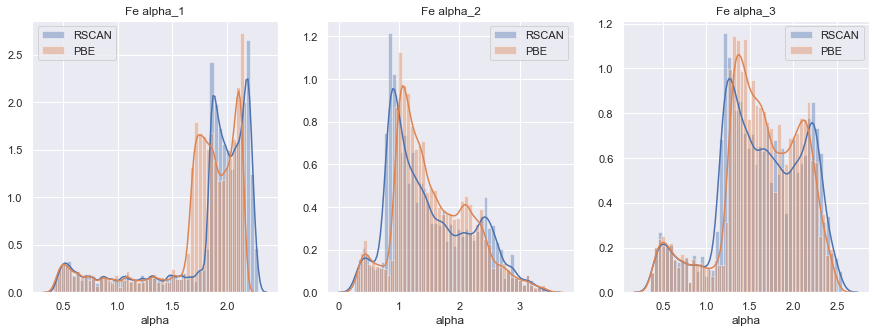

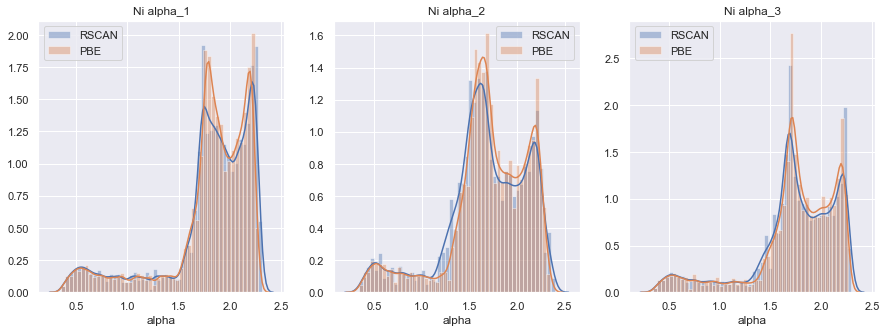

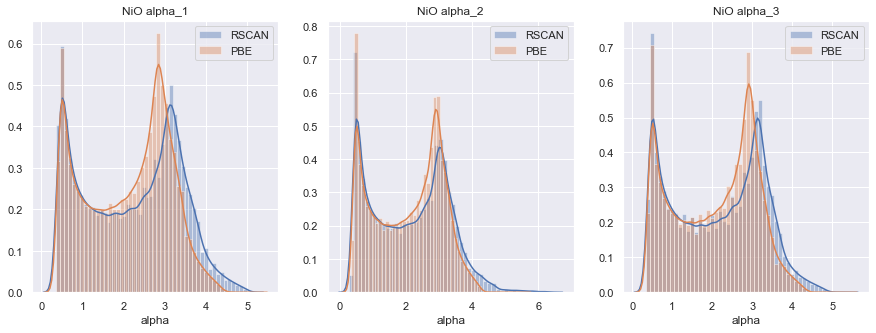

In [94]:
for element in mag_df.columns.levels[0]:
    histo_mega_plot(mag_df,element,3)

### Observations
PBE alpha distributions appear to have higher frequency peaks in most materials but follow very similar frequency distributions as for RSCAN.  
In Fe in particular, the peaks in PBE appear to be offset from the frequency peaks in RSCAN. This is observed to a lesser extent in Co and alpha_3 of NiO

## Non-spin Materials

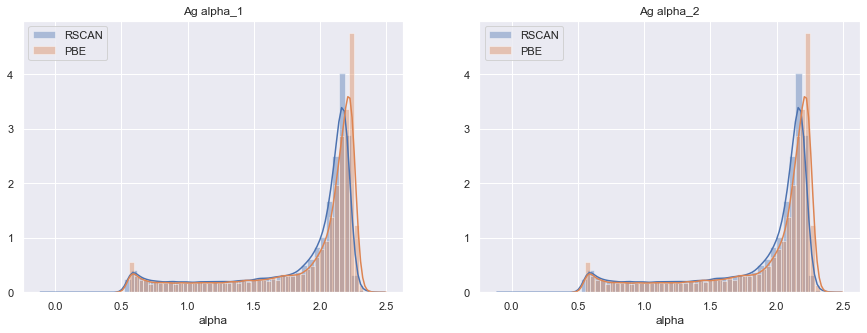

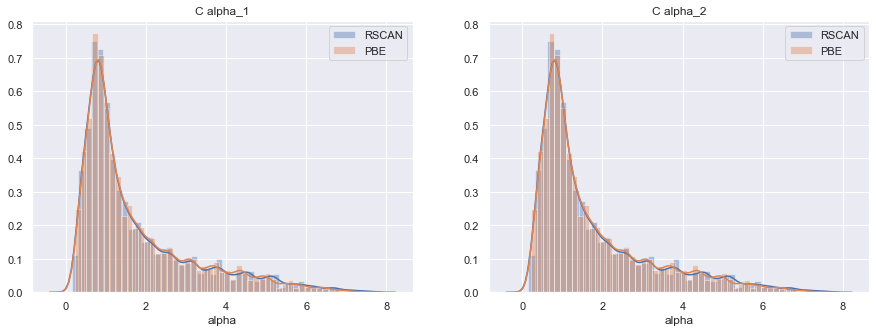

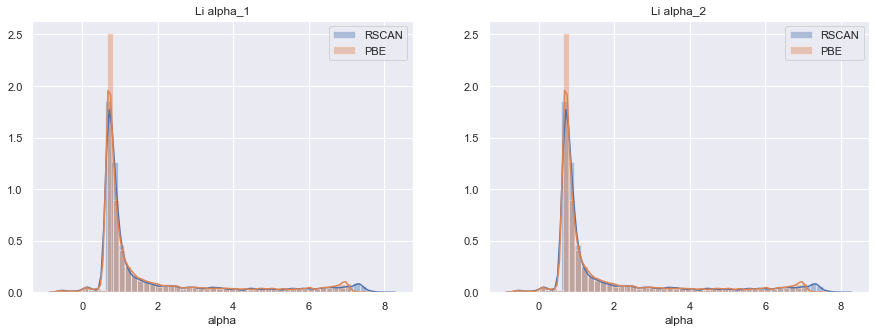

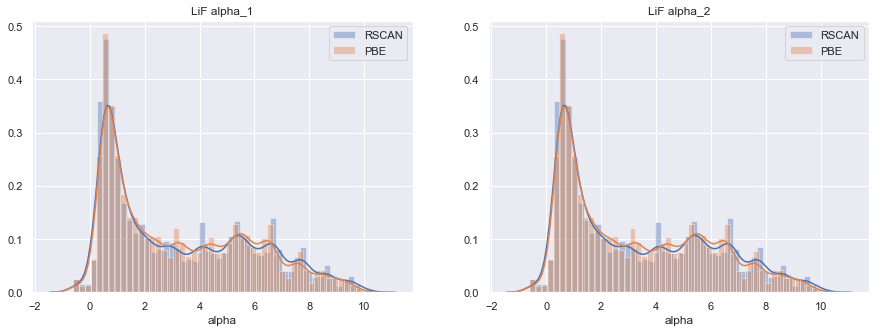

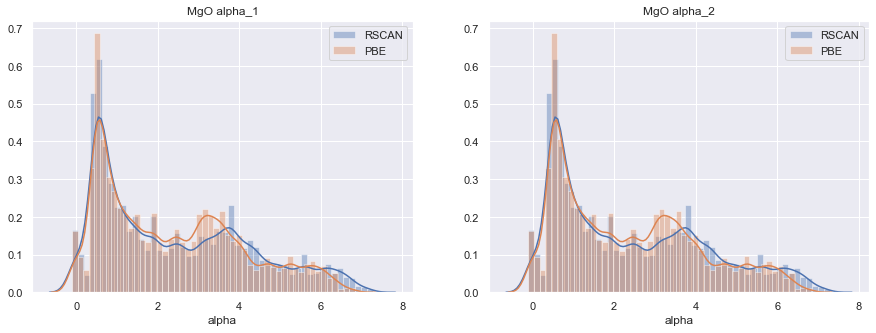

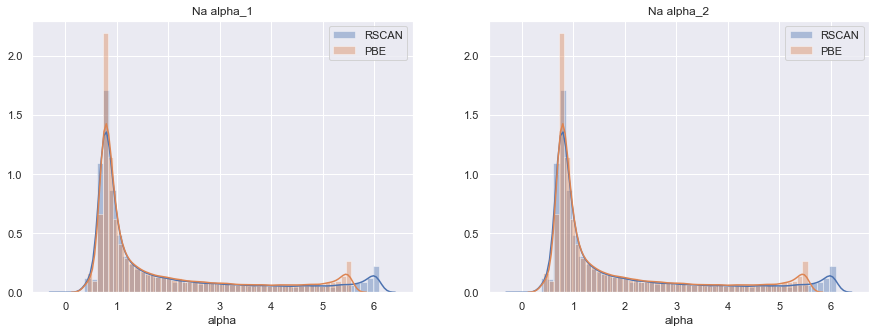

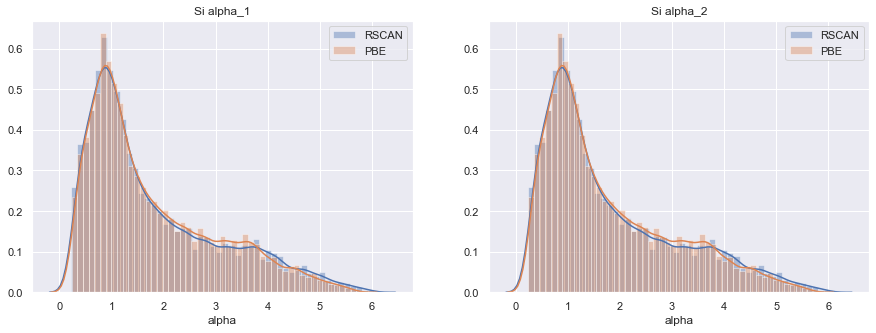

In [95]:
for element in non_mag_df.columns.levels[0]:
    histo_mega_plot(non_mag_df,element,2)

### Observations
PBE seems to have higher frequency peaks in some systems, especially in Na, MgO, Li and Ag. Overall, the shape of the frequency distributions is very similar for PBE and RASCAN. In Li, MgO and Na the high alpha tail of the distribution appears noticably offset between the two functionals. In Ag, the peaks centred on slightly different alpha values, as observed for the other metal calculations in the earlier figures. 

# Statistical Analysis
Statisitcal metrics to describe the similarity of RSACN and PBE alpha frequency distributions. 

## Spin-pol Materials

p_wilcox      p_ks  intersect   entropy
element alpha                                         
Co      1      0.445766  0.965485   0.929034  0.027876
        2      0.525653  0.999898   0.707412  0.342558
        3      1.000000  0.965485   0.796832  0.143899
Cu      1      0.657847  0.999898   0.894859  0.043939
        2      0.657847  0.999898   0.894859  0.043939
        3      0.657847  0.999898   0.894859  0.043939
Fe      1      0.158990  0.965485   0.833290  0.090513
        2      0.278965  0.770953   0.815501  0.210775
        3      0.313220  0.965485   0.881880  0.105350
Ni      1      0.666014  0.965485   0.966242  0.005730
        2      0.808234  0.965485   0.883702  0.056429
        3      0.910786  0.965485   0.882009  0.051472
NiO     1      0.601213  0.965485   0.844238  0.143333
        2      0.455273  0.770953   0.867615  0.060876
        3      0.519657  0.965485   0.878090  0.075604

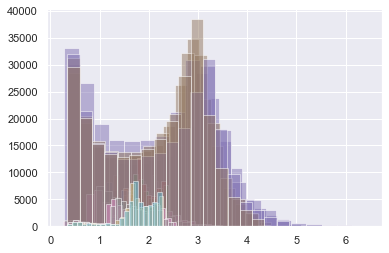

In [70]:
mag_comp = compare_hist(mag,mag_pbe)
mag_comp

### Observations
For Ni and Cu, the PBE and RSACN dist are basically indistinguishable based on the intersect and entropy values. Fe and Co are show larger differentiation between functionals. 

### Non-spin Materials

p_wilcox      p_ks  intersect   entropy
element alpha                                         
Ag      1      0.015240  0.770953   0.692713  0.135893
        2      0.015240  0.770953   0.692713  0.135893
C       1      0.206388  0.999898   0.883375  0.058600
        2      0.206388  0.999898   0.883375  0.058600
Li      1      0.001162  0.002571   0.448384  0.259759
        2      0.001162  0.002571   0.448384  0.259759
LiF     1      0.002067  0.497342   0.812835  0.014747
        2      0.002067  0.497342   0.812835  0.014747
MgO     1      0.695038  0.999898   0.954320  0.008067
        2      0.695038  0.999898   0.954320  0.008067
Na      1      0.033340  0.999898   0.588601  0.580882
        2      0.033340  0.999898   0.588601  0.580882
Si      1      0.247103  0.965485   0.967956  0.003235
        2      0.247103  0.965485   0.967956  0.003235

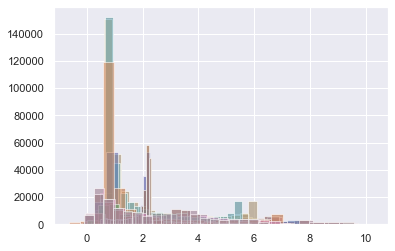

In [71]:
non_mag_comp = compare_hist(non_mag,non_mag_pbe)
non_mag_comp

### Are the non-mag materials more similar between RSCAN and PBE than for metals?